# Dataset Summary  Tables

In this notebook, we produce the high-level summary statistics of the dataset.

_This includes the appendix tables in our paper (printed as long latex strings!). There are probably neater ways to write this code._


In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from src.utils.helper_funcs import find_project_root, ensure_dir_exists
from src.utils.data_loader import (
    load_data,
    unnest_columns,
)
from src.viz.plot_config import *

# Apply Seaborn settings
sns.set(**seaborn_params)

# Apply Matplotlib settings
plt.rcParams.update(matplotlib_params)

# Set seed
np.random.seed(42)


# Set a path to store any results and make sure it exists
PROJECT_ROOT = find_project_root()
RESULTS_PATH = PROJECT_ROOT / "results"
ensure_dir_exists(RESULTS_PATH)

# Load data
data_dict = load_data()
# Unpack dictionary
for key, dataset in data_dict.items():
    # Unnest the survey columns for ease of analysis
    if key == "survey":
        nested_columns = ["location", "religion", "ethnicity"]
        dataset = unnest_columns(dataset, nested_columns)
        data_dict[key] = dataset
    # Inspect each dataset
    print(f"{key}: {dataset.shape}")
    display(dataset.head(2))
    print("\n")

survey: (1500, 48)


,user_id,survey_only,num_completed_conversations,timing_duration_s,timing_duration_mins,generated_datetime,consent,consent_age,lm_familiarity,lm_indirect_use,...,location_reside_subregion,location_reside_countryISO,location_same_birth_reside_country,location_special_region,religion_self_described,religion_categorised,religion_simplified,ethnicity_self_described,ethnicity_categorised,ethnicity_simplified
0,user0,False,1,266,4.43,2023-11-22 15:48:46,"Yes, I consent to take part",I certify that I am 18 years of age or over,Somewhat familiar,Yes,...,Northern America,CAN,Yes,Northern America,prefer not to say,Prefer not to say,Prefer not to say,prefer not to say,Prefer not to say,Prefer not to say
1,user1,False,6,632,10.53,2023-11-22 15:56:10,"Yes, I consent to take part",I certify that I am 18 years of age or over,Somewhat familiar,Yes,...,Northern America,CAN,Yes,Northern America,prefer not to say,Prefer not to say,Prefer not to say,caucasian,White,White




conversations: (8011, 13)


,conversation_id,user_id,included_in_balanced_subset,generated_datetime,timing_duration_s,timing_duration_mins,conversation_type,opening_prompt,conversation_turns,conversation_history,performance_attributes,choice_attributes,open_feedback
0,c0,user0,False,2023-11-22 15:55:46,401.07,6.68,unguided,What can you do about the inequality of wealth?,5,"[{'turn': 0, 'role': 'user', 'content': 'What ...","{'values': None, 'fluency': 95, 'factuality': ...","{'values': None, 'fluency': 80, 'factuality': ...",Shorter blocks would be nice. but has to ha...
1,c1,user1,True,2023-11-22 16:07:49,642.97,10.72,unguided,What can I do to start making extra money on t...,2,"[{'turn': 0, 'role': 'user', 'content': 'What ...","{'values': 50, 'fluency': 100, 'factuality': 1...","{'values': 50, 'fluency': 100, 'factuality': 1...",The first time I responded to the second quest...




utterances: (68371, 14)


,utterance_id,interaction_id,conversation_id,user_id,turn,within_turn_id,included_in_balanced_subset,conversation_type,user_prompt,model_response,model_name,model_provider,score,if_chosen
0,ut0,int0,c0,user0,0,0,False,unguided,What can you do about the inequality of wealth?,Make it illegal for corporations to own a majo...,google/flan-t5-xxl,huggingface_api,17,False
1,ut1,int0,c0,user0,0,1,False,unguided,What can you do about the inequality of wealth?,"As an AI language model, I cannot express pers...",command-light,cohere,92,True




models: (21, 15)


,long_name,short_name,longcode,model_family,model_provider,model_provider_type,model_type,default_params,selected_params,header,link,in_yaml,params_tested,endpoint_live,status
0,claude-2,claude-2,CL2,Anthropic,Anthropic,Commerical,Chat,"{'temperature': '1.0', 'top_p': '0.7', 'presen...","{'temperature': '1.0', 'top_p': '0.7', 'presen...",You are a conversational assistant. Limit your...,https://docs.anthropic.com/claude/reference/se...,Yes,Yes,Yes,Deployed Successfully
1,claude-2.1,claude-2.1,CL2*,Anthropic,Anthropic,Commerical,Chat,"{'temperature': '1.0', 'top_p': '0.7', 'presen...","{'temperature': '1.0', 'top_p': '0.7', 'presen...",You are a conversational assistant. Limit your...,https://docs.anthropic.com/claude/reference/se...,Yes,Yes,Yes,Deployed Successfully




metadata: (106554, 10)


,column_id,user_id,conversation_id,interaction_id,utterance_id,pii_flag,pii_manual_flag,language_flag,en_flag,moderation_flag
0,user_prompt,user840,c4659,int13826,None,False,NaN,en,True,"{'flagged': False, 'categories': {'sexual': Fa..."
1,user_prompt,user840,c4659,int13827,None,False,NaN,en,True,"{'flagged': False, 'categories': {'sexual': Fa..."


## General Table Functions

In [2]:
def format_count_and_pct_columns(
    styled_df, count_cols, bar_cols, cost_cols, pct=True, nan_mode=""
):
    formatting_dict = {}
    for col in count_cols:
        try:
            # Attempt to convert column to numeric type
            numeric_col = pd.to_numeric(styled_df.data[col], errors="raise")
            # If successful, apply formatting
            formatting_dict[col] = "{:,.0f}"
        except Exception:
            # If conversion fails, skip formatting
            pass

    if pct:
        for col in bar_cols:
            try:
                # Attempt to convert column to numeric type
                numeric_col = pd.to_numeric(styled_df.data[col], errors="raise")
                # If successful, apply percentage formatting
                formatting_dict[col] = "{:.1%}"
            except Exception:
                # If conversion fails, skip formatting
                pass
    if cost_cols is not None:
        for col in cost_cols:
            try:
                # Attempt to convert column to numeric type
                numeric_col = pd.to_numeric(styled_df.data[col], errors="raise")
                # If successful, apply percentage formatting
                formatting_dict[col] = "{:,.2f}"
            except Exception:
                # If conversion fails, skip formatting
                pass

    return styled_df.format(formatting_dict, na_rep=nan_mode)


def highlight_rows_html(row, headers):
    if row["Category"] in headers:
        styles = [
            "font-weight: bold; background-color: #2c3d4f; color: white; text-align: left;"
        ] + ["font-weight: bold; background-color: #2c3d4f; color: white;"] * (
            len(row) - 1
        )
    else:
        styles = [""] * len(row)
    return styles


# Function to insert custom latex commands for highlighting rows
def midline_rows_latex(df, header_indices):
    new_rows = []
    for index, row in df.iterrows():
        if index in header_indices:
            # Inserting midrule before and after the header row
            new_rows.append(["\\midrule", np.nan, np.nan])
            new_rows.append(
                [f"\\textbf{{{row['Category']}}}", np.nan, np.nan]
            )  # Bold text for the header row
            new_rows.append(["\\midrule", np.nan, np.nan])
        else:
            new_rows.append(row.values)
    return pd.DataFrame(new_rows, columns=df.columns)


def color_rows_latex(data, header_indices):
    if header_indices is not None:
        # Split the dataframe on the header indices
        split = np.split(data, header_indices)
        rejoins = []
        for sp in split:
            sp.index = pd.RangeIndex(len(sp.index))
            # Find places to alternate colors
            if len(sp) > 1:
                s = sp.index % 2 != 0
                s = pd.concat([pd.Series(s)] * data.shape[1], axis=1)
                z = pd.DataFrame(
                    np.where(s, "background-color:white", "background-color: #f2f2f2"),
                    index=sp.index,
                    columns=sp.columns,
                )
                # Set first row always equal to white
                z.iloc[0] = "background-color:white"
            else:
                # Always white
                z = pd.DataFrame(
                    "background-color: white", index=sp.index, columns=sp.columns
                )
            rejoins.append(z)

        colored_data = pd.concat(rejoins, axis=0, ignore_index=True)

    else:
        s = data.index % 2 != 0
        s = pd.concat([pd.Series(s)] * data.shape[1], axis=1)
        colored_data = pd.DataFrame(
            np.where(s, "background-color:#f2f2f2", "background-color: white"),
            index=data.index,
            columns=data.columns,
        )
    return colored_data


def apply_custom_styles_to_html(
    df,
    headers,
    category_cols,
    count_cols,
    bar_cols,
    cost_cols,
    highlight_row_headers=False,
    highlight_top_header=False,
    nan_mode="",
):

    # Add bars to 'Pct' columns
    styled_df = df.style.bar(
        subset=bar_cols, align="left", vmin=0, vmax=1, color="#d16249", width=70
    )

    # Format columns
    styled_df = format_count_and_pct_columns(
        styled_df,
        count_cols=count_cols,
        bar_cols=bar_cols,
        cost_cols=cost_cols,
        nan_mode=nan_mode,
    )

    # Italicize specific rows
    styled_df = styled_df.map(
        lambda val: (
            "font-style: italic"
            if val in ["Prefer not to say", "Other", "Prefer not to say/Other"]
            else ""
        ),
        subset=category_cols,
    )

    # Apply white bottom border to 'Pct' column cells
    styled_df = styled_df.apply(
        lambda row: [
            "border-bottom: 1px solid white" if col_name in bar_cols else ""
            for col_name in row.index
        ],
        axis=1,
    )

    # Additional custom styles
    shared_tab_properties = [
        {"selector": "th", "props": "text-align: center;"},
        {"selector": "tr:nth-of-type(odd)", "props": "background-color: #f7f7f7;"},
        {"selector": "tr:nth-of-type(even)", "props": "background-color: white;"},
        {
            "selector": ".dataframe",
            "props": [
                ("border-top", "2px solid black"),
                ("border-bottom", "2px solid black"),
            ],
        },
        {"selector": "tr", "props": [("height", "0px")]},
    ]

    if highlight_row_headers and highlight_top_header:
        # Logic for both True
        shared_tab_properties.append(
            {
                "selector": "th",
                "props": [
                    ("background-color", "#2c3d4f"),  # Header background color
                    ("color", "white"),  # Text color
                    ("font-weight", "bold"),  # Text weight (bold)
                    ("text-align", "left"),  # Text alignment
                ],
            }
        )
        styled_df = styled_df.apply(highlight_rows_html, headers=headers, axis=1)

    elif not highlight_row_headers and highlight_top_header:
        shared_tab_properties.append(
            {
                "selector": "th",
                "props": [
                    ("background-color", "#2c3d4f"),  # Header background color
                    ("color", "white"),  # Text color
                    ("font-weight", "bold"),  # Text weight (bold)
                    ("text-align", "left"),  # Text alignment
                ],
            }
        )

    elif highlight_row_headers and not highlight_top_header:
        shared_tab_properties.append({"selector": "thead", "props": "display: none;"})
        # Highlight intermeditary rows
        styled_df = styled_df.apply(highlight_rows_html, headers=headers, axis=1)

    # Set properties
    styled_df = styled_df.set_table_styles(
        table_styles=shared_tab_properties, overwrite=False
    )

    # Hide index
    styled_df = styled_df.hide(axis="index")

    return styled_df


def apply_custom_styles_to_latex(
    df,
    headers,
    category_cols,
    count_cols,
    bar_cols,
    cost_cols,
    highlight_row_headers=False,
    highlight_top_header=False,
    nan_mode="",
    environment=None,
):
    df_copy = df.copy()
    orig_cols = df_copy.columns

    # Convert bar columns to latex bar command strings
    for col in bar_cols:
        df_copy[f"{col}_latex_bar"] = df_copy[col].apply(
            lambda x: f"\\pcb{{{x*100:.1f}}}\\%" if not pd.isna(x) else np.nan
        )
        df_copy = df_copy.drop(columns=[col])
    df_copy = df_copy.rename(columns={f"{col}_latex_bar": col for col in bar_cols})

    # Make sure order is preserved
    df_copy = df_copy[orig_cols]

    # Track header rows and their indices
    if highlight_row_headers:
        header_indices = []
        for index, row in df_copy.iterrows():
            if row["Category"] in headers:
                header_indices.append(index)

        display(df_copy.head(5))
        df_copy = midline_rows_latex(df_copy, header_indices)

        # Update now we've added the midrule rows
        trio_header_indices = []
        for index, row in df_copy.iterrows():
            try:
                # Check if 'midrule' or 'textbf' in the category:
                if ("midrule" in row["Category"]) or ("textbf" in row["Category"]):
                    # Append index
                    trio_header_indices.append(index)
            except:
                print(index, row)

        if highlight_top_header:
            trio_header_indices = [0] + trio_header_indices

    # Convert to latex styled DataFrame
    styled_df = df_copy.style

    # # Format count and percentage columns
    styled_df = format_count_and_pct_columns(
        styled_df,
        count_cols=count_cols,
        bar_cols=bar_cols,
        cost_cols=cost_cols,
        pct=False,
        nan_mode=nan_mode,
    )

    # Italicize specific rows with latex
    styled_df = styled_df.apply(
        lambda row: [
            (
                "font-style: italic"
                if val in ["Prefer not to say", "Other", "Prefer not to say/Other"]
                else ""
            )
            for val in row
        ],
        axis=1,
        subset=category_cols,
    )

    if highlight_row_headers:
        styled_df = styled_df.apply(
            color_rows_latex, header_indices=trio_header_indices, axis=None
        )
    elif highlight_top_header:
        styled_df = styled_df.apply(color_rows_latex, header_indices=None, axis=None)

    # Additional LaTeX table styles
    shared_tab_properties = [
        {"selector": "toprule", "props": ":toprule;"},
        {"selector": "midrule", "props": ":midrule;"},
        {"selector": "bottomrule", "props": ":bottomrule;"},
    ]

    if highlight_row_headers and highlight_top_header:
        shared_tab_properties.append(
            {
                "selector": "th",
                "props": [
                    ("color", "black"),  # Text color
                    ("font-weight", "bold"),  # Text weight (bold)
                    ("text-align", "left"),  # Text alignment
                ],
            }
        )

    # Set properties
    styled_df = styled_df.set_table_styles(
        table_styles=shared_tab_properties, overwrite=True
    )

    # Remove index
    styled_df = styled_df.hide(axis="index")

    # Convert to LaTeX
    latex_str = styled_df.to_latex(
        hrules=True,
        convert_css=True,
        environment=environment,
        caption="ADD CAPTION HERE",
        label="tab:ADD_LABEL_HERE",
    )

    inside_string = "& {\\cellcolor{white}} " + f"{nan_mode} "
    midrule_replace = (
        "{\\cellcolor{white}} \\midrule "
        + inside_string * (len(df_copy.columns) - 1)
        + "\\\\"
    )
    latex_str = (
        latex_str.replace(
            midrule_replace,
            "\\midrule",
        )
        .replace("\\theadnone", "")
        .replace("\\thblack", "")
    )

    return latex_str


def styler_by_format(
    df,
    headers,
    category_cols=["Category"],
    count_cols=["Count"],
    bar_cols=["Pct"],
    cost_cols=None,
    format="latex",
    highlight_mode="rows",
    environment=None,
    nan_mode="",
):
    if highlight_mode == "rows":
        highlight_row_headers = True
        highlight_top_header = False
    elif highlight_mode == "top":
        highlight_row_headers = False
        highlight_top_header = True
    elif highlight_mode == "both":
        highlight_row_headers = True
        highlight_top_header = True
    if format == "html":
        print("HTML")
        styled_df = apply_custom_styles_to_html(
            df,
            headers,
            category_cols,
            count_cols,
            bar_cols,
            cost_cols,
            highlight_row_headers,
            highlight_top_header,
            nan_mode=nan_mode,
        )
    elif format == "latex":
        print("Latex")
        styled_df = apply_custom_styles_to_latex(
            df,
            headers,
            category_cols,
            count_cols,
            bar_cols,
            cost_cols,
            highlight_row_headers,
            highlight_top_header,
            nan_mode=nan_mode,
            environment=environment,
        )
    return styled_df

# The Survey

## Full Demographics

### Setup

In [3]:
columns = []
categorical = {
    "age": "Age",
    "gender": "Gender",
    "ethnicity_categorised": "Self-Reported Ethnicity*",
    "religion_categorised": "Self-Reported Religion*",
    "employment_status": "Employment Status",
    "education": "Education",
    "marital_status": "Martial Status",
    "english_proficiency": "English Proficiency",
    "location_special_region": "Regions",
}


headers = [
    "Total Participants",
]
rows = []
data = data_dict["survey"]
just_survey = data[data["survey_only"] == True]
with_convos = data[data["survey_only"] == False]
# Inital rows
rows.append(["Total Participants", len(data), np.nan])
# More initial rows
rows.append(["With conversations", len(with_convos), len(with_convos) / len(data)])
rows.append(["Just survey", len(just_survey), len(just_survey) / len(data)])
# Loop through columns
for c, l in categorical.items():
    headers.append(l)
    r = data[c].value_counts(dropna=False)
    sum = r.sum()
    # Initialize an empty series to hold special cases
    special_cases = pd.Series(dtype=r.dtype)
    # Check for "Prefer not to say" and "Other", extract and drop them
    if "Other" in r.keys():
        other = r["Other"]
        r = r.drop("Other")
        # Add "Other" to special cases series
        special_cases["Other"] = other
    if "Prefer not to say" in r.keys():
        pnts = r["Prefer not to say"]
        r = r.drop("Prefer not to say")
        # Add "Prefer not to say" to special cases series
        special_cases["Prefer not to say"] = pnts

    # Sort the remaining data
    sorted_data = r.sort_values(ascending=False)
    # Concatenate sorted data with special cases
    r_sort = pd.concat([sorted_data, special_cases])
    r_pct = r_sort / sum
    r_combine = pd.concat([r_sort, r_pct], ignore_index=True, axis=1)
    r_combine.columns = ["count", "pct"]
    rows.append([l, np.nan, np.nan])
    # Unpack r (put prefer not to say last)
    for i, row in r_combine.iterrows():
        rows.append([i, row["count"], row["pct"]])

# Dataframe
df = pd.DataFrame(rows, columns=["Category", "Count", "Pct"])

### HTML Version

In [4]:
styler_by_format(df, headers, format="html", highlight_mode="rows")

HTML


Category,Count,Pct
Total Participants,"1,500",
With conversations,"1,396",93.1%
Just survey,104,6.9%
Age,,
25-34 years old,454,30.3%
18-24 years old,297,19.8%
35-44 years old,237,15.8%
45-54 years old,208,13.9%
55-64 years old,197,13.1%
65+ years old,106,7.1%


### Latex Version

In [5]:
print(styler_by_format(df, headers, format="latex", highlight_mode="rows"))

Latex


,Category,Count,Pct
0,Total Participants,1500.0,NaN
1,With conversations,1396.0,\pcb{93.1}\%
2,Just survey,104.0,\pcb{6.9}\%
3,Age,NaN,NaN
4,25-34 years old,454.0,\pcb{30.3}\%


\begin{table}
\caption{ADD CAPTION HERE}
\label{tab:ADD_LABEL_HERE}
\begin{tabular}{lrl}
\toprule
Category & Count & Pct \\
\midrule
\midrule
{\cellcolor{white}} \textbf{Total Participants} & {\cellcolor{white}}  & {\cellcolor{white}}  \\
\midrule
{\cellcolor{white}} With conversations & {\cellcolor{white}} 1,396 & {\cellcolor{white}} \pcb{93.1}\% \\
{\cellcolor[HTML]{F2F2F2}} Just survey & {\cellcolor[HTML]{F2F2F2}} 104 & {\cellcolor[HTML]{F2F2F2}} \pcb{6.9}\% \\
\midrule
{\cellcolor{white}} \textbf{Age} & {\cellcolor{white}}  & {\cellcolor{white}}  \\
\midrule
{\cellcolor{white}} 25-34 years old & {\cellcolor{white}} 454 & {\cellcolor{white}} \pcb{30.3}\% \\
{\cellcolor[HTML]{F2F2F2}} 18-24 years old & {\cellcolor[HTML]{F2F2F2}} 297 & {\cellcolor[HTML]{F2F2F2}} \pcb{19.8}\% \\
{\cellcolor{white}} 35-44 years old & {\cellcolor{white}} 237 & {\cellcolor{white}} \pcb{15.8}\% \\
{\cellcolor[HTML]{F2F2F2}} 45-54 years old & {\cellcolor[HTML]{F2F2F2}} 208 & {\cellcolor[HTML]{F2F2F2}} \pcb{

/Users/hannahrosekirk/opt/anaconda3/envs/prism/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


## Full Geographics Table

In [6]:
columns = []
categorical = {
    "location_birth_country": "Born",
    "location_reside_country": "Reside",
}

frames = []
data = data_dict["survey"]
# Loop through columns
for c, l in categorical.items():
    r = data[c].value_counts(dropna=False)
    sum = r.sum()
    # Sort the data
    r_sort = r.sort_values(ascending=False)
    r_pct = r_sort / sum
    r_combine = pd.concat([r_sort, r_pct], ignore_index=True, axis=1)
    r_combine.columns = [l, "%"]
    frames.append(r_combine)

# Dataframe
df = frames[0].merge(
    frames[1], left_index=True, right_index=True, how="outer", indicator=True
)

# Convert Categorical columns to 'object'
for col in df.select_dtypes(["category"]).columns:
    df[col] = df[col].astype("object")

# Replace NaN values with 0 and sort dataframe
df = df.fillna(0).sort_values(by="Born", ascending=False).drop(columns="_merge")
# Make sure Prefer not to say is last (without using append)
df_filtered = df.drop(index="Prefer not to say", errors="ignore")

# Filter the 'Prefer not to say' rows
df_prefer_not_to_say = df.loc[
    [index for index in df.index if index == "Prefer not to say"]
]

# Append 'Prefer not to say' rows to the end
df = pd.concat([df_filtered, df_prefer_not_to_say])

df = df.reset_index().rename(columns={"index": "Country"})
columns = ["Category", "Born", "Pct Born", "Reside", "Pct Reside"]
df.columns = columns

bar_cols = ["Pct Born", "Pct Reside"]
count_cols = ["Born", "Reside"]
category_cols = ["Category"]

### HTML Version

In [7]:
styler_by_format(
    df,
    headers,
    category_cols,
    count_cols,
    bar_cols,
    format="html",
    highlight_mode="top",
)

HTML


Category,Born,Pct Born,Reside,Pct Reside
United States,338,22.5%,386,25.7%
United Kingdom,292,19.5%,340,22.7%
South Africa,91,6.1%,86,5.7%
Mexico,69,4.6%,67,4.5%
Australia,65,4.3%,72,4.8%
New Zealand,64,4.3%,77,5.1%
Chile,63,4.2%,65,4.3%
Canada,50,3.3%,54,3.6%
Israel,47,3.1%,61,4.1%
Nigeria,19,1.3%,0,0.0%


### Latex Version

In [8]:
print(
    styler_by_format(
        df,
        headers,
        category_cols,
        count_cols,
        bar_cols,
        format="latex",
        highlight_mode="top",
    )
)

Latex
\begin{table}
\caption{ADD CAPTION HERE}
\label{tab:ADD_LABEL_HERE}
\begin{tabular}{lrlrl}
\toprule
Category & Born & Pct Born & Reside & Pct Reside \\
\midrule
{\cellcolor{white}} United States & {\cellcolor{white}} 338 & {\cellcolor{white}} \pcb{22.5}\% & {\cellcolor{white}} 386 & {\cellcolor{white}} \pcb{25.7}\% \\
{\cellcolor[HTML]{F2F2F2}} United Kingdom & {\cellcolor[HTML]{F2F2F2}} 292 & {\cellcolor[HTML]{F2F2F2}} \pcb{19.5}\% & {\cellcolor[HTML]{F2F2F2}} 340 & {\cellcolor[HTML]{F2F2F2}} \pcb{22.7}\% \\
{\cellcolor{white}} South Africa & {\cellcolor{white}} 91 & {\cellcolor{white}} \pcb{6.1}\% & {\cellcolor{white}} 86 & {\cellcolor{white}} \pcb{5.7}\% \\
{\cellcolor[HTML]{F2F2F2}} Mexico & {\cellcolor[HTML]{F2F2F2}} 69 & {\cellcolor[HTML]{F2F2F2}} \pcb{4.6}\% & {\cellcolor[HTML]{F2F2F2}} 67 & {\cellcolor[HTML]{F2F2F2}} \pcb{4.5}\% \\
{\cellcolor{white}} Australia & {\cellcolor{white}} 65 & {\cellcolor{white}} \pcb{4.3}\% & {\cellcolor{white}} 72 & {\cellcolor{white}} \pcb{4

## LLM Usage

In [9]:
llm_usage = data_dict["survey"][
    [
        "lm_direct_use",
        "lm_indirect_use",
        "lm_familiarity",
        "lm_frequency_use",
        "lm_usecases",
    ]
]
llm_usage.head(2)

,lm_direct_use,lm_indirect_use,lm_familiarity,lm_frequency_use,lm_usecases
0,Yes,Yes,Somewhat familiar,More than once a month,"{'homework_assistance': 0, 'research': 0, 'sou..."
1,No,Yes,Somewhat familiar,More than once a month,"{'homework_assistance': 0, 'research': 1, 'sou..."


In [10]:
# Find people not shown the Use Case and Frequency Questions
n_not_shown = len(llm_usage) - len(llm_usage["lm_frequency_use"].dropna())
n_shown = len(llm_usage["lm_frequency_use"].dropna())
print(
    f"Number of participants not shown the Use Case and Frequency Questions: {n_not_shown}"
)
print(f"Number of participants shown: {n_shown}")

# Convert to a percentage
pct_not_shown = n_not_shown / len(llm_usage)
print(
    f"Percentage of participants not shown the Use Case and Frequency Questions: {pct_not_shown:.2%}"
)
print(
    f"Percentage of participants shown (have directly or indirectly used LLMs): {1-pct_not_shown:.2%}"
)

Number of participants not shown the Use Case and Frequency Questions: 247
Number of participants shown: 1253
Percentage of participants not shown the Use Case and Frequency Questions: 16.47%
Percentage of participants shown (have directly or indirectly used LLMs): 83.53%


In [11]:
categorical = {
    "lm_direct_use": "LLM Direct Use",
    "lm_indirect_use": "LLM Indirect Use",
    "lm_frequency_use": "LLM Frequency of Use",
    "lm_familiarity": "LLM Familiarity",
}

headers = []
rows = []
data = data_dict["survey"][
    [
        "lm_direct_use",
        "lm_indirect_use",
        "lm_frequency_use",
        "lm_familiarity",
        "lm_usecases",
    ]
].copy()

# Loop through columns
for c, l in categorical.items():
    headers.append(l)
    r = data[c].value_counts(dropna=False)
    sum = r.sum()
    # Initialize an empty series to hold special cases
    special_cases = pd.Series(dtype=r.dtype)
    # Check for "Prefer not to say" and "Other", extract and drop them
    if None in r.keys():
        # Replace "None" with (not shown question)
        special_cases["Not shown question"] = r[None]
    if "Other" in r.keys():
        other = r["Other"]
        r = r.drop("Other")
        # Add "Other" to special cases series
        special_cases["Other"] = other
    if "Prefer not to say" in r.keys():
        pnts = r["Prefer not to say"]
        r = r.drop("Prefer not to say")
        # Add "Prefer not to say" to special cases series
        special_cases["Prefer not to say"] = pnts

    # Sort the remaining data
    sorted_data = r.sort_values(ascending=False)
    # Concatenate sorted data with special cases
    r_sort = pd.concat([sorted_data, special_cases])
    r_pct = r_sort / sum
    r_combine = pd.concat([r_sort, r_pct], ignore_index=True, axis=1)
    r_combine.columns = ["count", "pct"]
    rows.append([l, np.nan, np.nan])
    # Unpack r (put prefer not to say last)
    for i, row in r_combine.iterrows():
        rows.append([i, row["count"], row["pct"]])

# Dataframe
df = pd.DataFrame(rows, columns=["Category", "Count", "Pct"])

# Drop any rows where Category is None
df = df.dropna(subset=["Category"])

df.head(4)

,Category,Count,Pct
0,LLM Direct Use,NaN,NaN
1,Yes,1162.0,0.774667
2,No,259.0,0.172667
3,Unsure,79.0,0.052667


### Other Usecases

In [12]:
survey = data_dict["survey"]
nested_columns = ["lm_usecases"]
survey = unnest_columns(survey, nested_columns)
other_text = survey[[c for c in survey.columns if "other_text" in c]].dropna()

print(len(other_text))

# Print sample

# Print a sample
for i in range(5):
    print(other_text.iloc[i].values)

124
['Creating Drawing']
['Help with writing mails']
['Played around with it a few times out of curiousity']
['Character "Roleplaying"']
['General faffing about']


### Binary Usecases

In [13]:
# Now loop through lm_usecases
counts = Counter()
other_texts = []

# Iterate through each row in the dataframe
for index, row in data.iterrows():
    # Get the dictionary from the 'lm_usecases' column
    lm_usecases_dict = row["lm_usecases"]
    # Pop the other_text
    other_text = lm_usecases_dict.pop("other_text", None)
    if other_text is not None:
        other_texts.append(other_text)

    # Replace v=None with v=0
    lm_usecases_dict = {
        k: v if v is not None else 0 for k, v in lm_usecases_dict.items()
    }

    # Update the counts for each key in the dictionary
    counts.update(lm_usecases_dict)

# Create dataframe of usecase counts
usecase_df = pd.DataFrame(counts.items(), columns=["Category", "Count"]).sort_values(
    by="Count", ascending=False
)
# Move "other" to the end
other = usecase_df[usecase_df["Category"].str.lower().str.contains("other")]
usecase_df = usecase_df[~usecase_df["Category"].str.lower().str.contains("other")]
usecase_df = pd.concat([usecase_df, other])

# Add percentage column
usecase_df["Pct"] = usecase_df["Count"] / n_shown

usecase_df.head(4)

,Category,Count,Pct
1,research,617,0.492418
3,professional_work,469,0.374302
4,creative_writing,392,0.312849
8,technical_or_programming_help,337,0.268955


In [14]:
# Load mapping for longer names
usecase_mapping = pd.read_csv(
    PROJECT_ROOT / "data" / "storage" / "mappings" / "header_usecases_mapping.csv"
)
usecase_mapping.head(2)
# Turn into dictionary of header:survey_text
usecase_mapping_dict = usecase_mapping.set_index("header")["survey_text"].to_dict()

usecase_mapping_dict

{'shared_opener': 'Which of the following scenarios best describe how and why you use AI language models? Select all that apply. - Selected Choice - ',
 'homework_assistance': '**Homework Assistance**: Getting help with school or university assignments.',
 'research': '**Research**: Fact-checking or gaining overviews on specific topics.',
 'source_suggestions': '**Source Suggestions**: Creating or finding bibliographies, information sources or reading lists.',
 'professional_work': '**Professional Work**: Assisting in drafting, editing, or brainstorming content for work.',
 'creative_writing': '**Creative Writing**: Generating story ideas, dialogues, poems or other writing prompts.',
 'casual_conversation': '**Casual Conversation**: Engaging in small talk, casual chats, or joke generation.',
 'personal_recommendations': '**Personal Recommendations**: Seeking book, music or movie recommendations.',
 'daily_productivity': '**Daily Productivity**: Setting reminders, making to-do lists, or

In [15]:
# Map onto usecase_df
usecase_df["Category"] = usecase_df["Category"].map(
    lambda x: usecase_mapping_dict[x] if x in usecase_mapping_dict else x
)
usecase_df.head(2)

,Category,Count,Pct
1,**Research**: Fact-checking or gaining overvie...,617,0.492418
3,"**Professional Work**: Assisting in drafting, ...",469,0.374302


In [16]:
# Concatenate
header_row = {"Category": "LLM Use Cases", "Count": np.nan, "Pct": np.nan}
headers.append("LLM Use Cases")
usecase_df = pd.concat([pd.DataFrame([header_row]), usecase_df], ignore_index=True)
combined_df = pd.concat([df, usecase_df], ignore_index=True)

In [17]:
# Set up columns
category_cols = ["Category"]
count_cols = ["Count"]
bar_cols = ["Pct"]
cost_cols = None

### HTML Version

In [18]:
styler_by_format(
    combined_df,
    headers,
    category_cols,
    count_cols,
    bar_cols,
    cost_cols,
    format="html",
    highlight_mode="rows",
    environment=None,
    nan_mode="",
)

HTML


Category,Count,Pct
LLM Direct Use,,
Yes,"1,162",77.5%
No,259,17.3%
Unsure,79,5.3%
LLM Indirect Use,,
Yes,"1,104",73.6%
No,215,14.3%
Unsure,181,12.1%
LLM Frequency of Use,,
Once per month,374,24.9%


In [19]:
latex_string = styler_by_format(
    combined_df,
    headers,
    category_cols,
    count_cols,
    bar_cols,
    cost_cols,
    format="latex",
    highlight_mode="rows",
    environment="longtable",
    nan_mode="",
)

latex_string = latex_string.replace("**:", "}:").replace("**", "\\textbf{")
print(latex_string)

Latex


,Category,Count,Pct
0,LLM Direct Use,NaN,NaN
1,Yes,1162.0,\pcb{77.5}\%
2,No,259.0,\pcb{17.3}\%
3,Unsure,79.0,\pcb{5.3}\%
4,LLM Indirect Use,NaN,NaN


\begin{longtable}{lrl}
\caption{ADD CAPTION HERE} \label{tab:ADD_LABEL_HERE} \\
\toprule
Category & Count & Pct \\
\midrule
\endfirsthead
\caption[]{ADD CAPTION HERE} \\
\toprule
Category & Count & Pct \\
\midrule
\endhead
\midrule
\multicolumn{3}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
\midrule
{\cellcolor{white}} \textbf{LLM Direct Use} & {\cellcolor{white}}  & {\cellcolor{white}}  \\
\midrule
{\cellcolor{white}} Yes & {\cellcolor{white}} 1,162 & {\cellcolor{white}} \pcb{77.5}\% \\
{\cellcolor[HTML]{F2F2F2}} No & {\cellcolor[HTML]{F2F2F2}} 259 & {\cellcolor[HTML]{F2F2F2}} \pcb{17.3}\% \\
{\cellcolor{white}} Unsure & {\cellcolor{white}} 79 & {\cellcolor{white}} \pcb{5.3}\% \\
\midrule
{\cellcolor{white}} \textbf{LLM Indirect Use} & {\cellcolor{white}}  & {\cellcolor{white}}  \\
\midrule
{\cellcolor{white}} Yes & {\cellcolor{white}} 1,104 & {\cellcolor{white}} \pcb{73.6}\% \\
{\cellcolor[HTML]{F2F2F2}} No & {\cellcolor[HTML]{F2F2F2}} 215 & {\cellcolor[H

/Users/hannahrosekirk/opt/anaconda3/envs/prism/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


# Comparing to Other Papers

### Existing Demographics

In [20]:
df = pd.read_csv(
    PROJECT_ROOT
    / "data"
    / "storage"
    / "other_dataset_comparisons"
    / "existing_demographics.csv"
)
# Replace "Unanmed:0" with Category
df = df.rename(columns={"Unnamed: 0": "Category"})

df = df.replace("-", np.nan)

headers = ["Total Participants", "Demographic Respondents"]
for i, row in df.iterrows():
    # If values are nan
    if pd.isna(row.iloc[1]):
        headers.append(row.iloc[0])

bar_cols = [c for c in df.columns if c != "Category"]
count_cols = []
category_cols = ["Category"]

# Split out the first two rows and save
df_header = df.iloc[:2, :].copy()
# Get rest of rows (with header)
df_num_rows = df.iloc[2:, :].copy()
# Convert to numeric
for col in bar_cols:
    df_num_rows[col] = df_num_rows[col].apply(pd.to_numeric, errors="coerce") / 100

# Convert to numeric
for col in bar_cols:
    df_header[col] = df_header[col].apply(pd.to_numeric, errors="coerce")

print(headers)

full_df = df.copy()
for col in bar_cols:
    full_df[col] = full_df[col].apply(pd.to_numeric, errors="coerce") / 100
for col in count_cols:
    full_df[col] = full_df[col].apply(pd.to_numeric, errors="coerce")

['Total Participants', 'Demographic Respondents', 'Gender', 'Sexual Orientation', 'Age', 'Ethnicity', 'Education']


### HTML Version

In [21]:
styler_by_format(
    df_header,
    headers,
    category_cols,
    bar_cols,
    [],
    format="html",
    highlight_mode="top",
    nan_mode="-",
)
styler_by_format(
    df_num_rows,
    headers,
    category_cols,
    count_cols,
    bar_cols,
    format="html",
    highlight_mode="rows",
    nan_mode="-",
)

HTML
HTML


Category,"Bai et al., 2022","Ouyang et al., 2022","Glaese et al., 2022","Ganguli et al., 2022","Stiennon et al., 2020",Ours
Gender,-,-,-,-,-,-
Male,53.6%,47.4%,45.0%,47.0%,38.1%,50.4%
Female,46.4%,42.1%,54.0%,52.2%,61.9%,47.9%
Non-binary,0.0%,5.3%,1.0%,0.9%,0.0%,1.3%
Prefer not to say/Other,0.0%,5.3%,0.0%,0.0%,0.0%,0.4%
Sexual Orientation,-,-,-,-,-,-
Heterosexual,89.3%,-,84.0%,81.7%,-,-
Lesbian or Gay,7.1%,-,5.0%,4.3%,-,-
Bisexual,0.0%,-,9.0%,12.2%,-,-
Uncertain,3.6%,-,-,0.9%,-,-


### Latex Version

In [22]:
print(
    styler_by_format(
        df_header,
        headers,
        category_cols,
        bar_cols,
        [],
        format="latex",
        highlight_mode="top",
        environment=None,
        nan_mode="-",
    )
)
print(
    styler_by_format(
        df_num_rows,
        headers,
        category_cols,
        count_cols,
        bar_cols,
        format="latex",
        highlight_mode="rows",
        environment=None,
        nan_mode="-",
    )
)

Latex
\begin{table}
\caption{ADD CAPTION HERE}
\label{tab:ADD_LABEL_HERE}
\begin{tabular}{lrrrrrr}
\toprule
Category & Bai et al., 2022 & Ouyang et al., 2022 & Glaese et al., 2022 & Ganguli et al., 2022 & Stiennon et al., 2020 & Ours \\
\midrule
{\cellcolor{white}} Total Participants & {\cellcolor{white}} 28 & {\cellcolor{white}} 40 & {\cellcolor{white}} - & {\cellcolor{white}} 324 & {\cellcolor{white}} - & {\cellcolor{white}} 1,500 \\
{\cellcolor[HTML]{F2F2F2}} Demographic Respondents & {\cellcolor[HTML]{F2F2F2}} 28 & {\cellcolor[HTML]{F2F2F2}} 19 & {\cellcolor[HTML]{F2F2F2}} 533 & {\cellcolor[HTML]{F2F2F2}} 115 & {\cellcolor[HTML]{F2F2F2}} 21 & {\cellcolor[HTML]{F2F2F2}} 1,500 \\
\bottomrule
\end{tabular}
\end{table}

Latex


,Category,"Bai et al., 2022","Ouyang et al., 2022","Glaese et al., 2022","Ganguli et al., 2022","Stiennon et al., 2020",Ours
2,Gender,NaN,NaN,NaN,NaN,NaN,NaN
3,Male,\pcb{53.6}\%,\pcb{47.4}\%,\pcb{45.0}\%,\pcb{47.0}\%,\pcb{38.1}\%,\pcb{50.4}\%
4,Female,\pcb{46.4}\%,\pcb{42.1}\%,\pcb{54.0}\%,\pcb{52.2}\%,\pcb{61.9}\%,\pcb{47.9}\%
5,Non-binary,\pcb{0.0}\%,\pcb{5.3}\%,\pcb{1.0}\%,\pcb{0.9}\%,\pcb{0.0}\%,\pcb{1.3}\%
6,Prefer not to say/Other,\pcb{0.0}\%,\pcb{5.3}\%,\pcb{0.0}\%,\pcb{0.0}\%,\pcb{0.0}\%,\pcb{0.4}\%


\begin{table}
\caption{ADD CAPTION HERE}
\label{tab:ADD_LABEL_HERE}
\begin{tabular}{lllllll}
\toprule
Category & Bai et al., 2022 & Ouyang et al., 2022 & Glaese et al., 2022 & Ganguli et al., 2022 & Stiennon et al., 2020 & Ours \\
\midrule
\midrule
{\cellcolor{white}} \textbf{Gender} & {\cellcolor{white}} - & {\cellcolor{white}} - & {\cellcolor{white}} - & {\cellcolor{white}} - & {\cellcolor{white}} - & {\cellcolor{white}} - \\
\midrule
{\cellcolor{white}} Male & {\cellcolor{white}} \pcb{53.6}\% & {\cellcolor{white}} \pcb{47.4}\% & {\cellcolor{white}} \pcb{45.0}\% & {\cellcolor{white}} \pcb{47.0}\% & {\cellcolor{white}} \pcb{38.1}\% & {\cellcolor{white}} \pcb{50.4}\% \\
{\cellcolor[HTML]{F2F2F2}} Female & {\cellcolor[HTML]{F2F2F2}} \pcb{46.4}\% & {\cellcolor[HTML]{F2F2F2}} \pcb{42.1}\% & {\cellcolor[HTML]{F2F2F2}} \pcb{54.0}\% & {\cellcolor[HTML]{F2F2F2}} \pcb{52.2}\% & {\cellcolor[HTML]{F2F2F2}} \pcb{61.9}\% & {\cellcolor[HTML]{F2F2F2}} \pcb{47.9}\% \\
{\cellcolor{white}} Non-binary &

/Users/hannahrosekirk/opt/anaconda3/envs/prism/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


## Existing Geographics

In [23]:
df = pd.read_csv(
    PROJECT_ROOT
    / "data"
    / "storage"
    / "other_dataset_comparisons"
    / "existing_geographics.csv"
)
# Replace "Unanmed:0" with Category
df = df.rename(columns={"Unnamed: 0": "Category"})

bar_cols = [c for c in df.columns if c != "Category"]
print(bar_cols)
# Convert to numeric
for col in bar_cols:
    df[col] = df[col].apply(pd.to_numeric, errors="coerce") / 100
headers = []
count_cols = []
category_cols = ["Category"]

['Bai et al., 2022', 'Ouyang et al., 2022', 'Glaese et al., 2022', 'Ganguli et al., 2022', 'Stiennon et al., 2020', 'Ours']


### HTML version

In [24]:
styler_by_format(
    df,
    headers,
    category_cols,
    count_cols,
    bar_cols,
    format="html",
    highlight_mode="top",
    nan_mode="-",
)

HTML


Category,"Bai et al., 2022","Ouyang et al., 2022","Glaese et al., 2022","Ganguli et al., 2022","Stiennon et al., 2020",Ours
United States,100.0%,17.0%,0.0%,100.0%,60.0%,26.0%
United Kingdom,0.0%,0.0%,100.0%,0.0%,7.0%,23.0%
Philippines,0.0%,22.0%,0.0%,0.0%,7.0%,0.0%
Bangladesh,0.0%,22.0%,0.0%,0.0%,0.0%,0.0%
All Others,0.0%,39.0%,0.0%,0.0%,27.0%,51.0%


### Latex Version

In [25]:
print(
    styler_by_format(
        df,
        headers,
        category_cols,
        count_cols,
        bar_cols,
        format="latex",
        highlight_mode="top",
        nan_mode="-",
    )
)

Latex
\begin{table}
\caption{ADD CAPTION HERE}
\label{tab:ADD_LABEL_HERE}
\begin{tabular}{lllllll}
\toprule
Category & Bai et al., 2022 & Ouyang et al., 2022 & Glaese et al., 2022 & Ganguli et al., 2022 & Stiennon et al., 2020 & Ours \\
\midrule
{\cellcolor{white}} United States & {\cellcolor{white}} \pcb{100.0}\% & {\cellcolor{white}} \pcb{17.0}\% & {\cellcolor{white}} \pcb{0.0}\% & {\cellcolor{white}} \pcb{100.0}\% & {\cellcolor{white}} \pcb{60.0}\% & {\cellcolor{white}} \pcb{26.0}\% \\
{\cellcolor[HTML]{F2F2F2}} United Kingdom & {\cellcolor[HTML]{F2F2F2}} \pcb{0.0}\% & {\cellcolor[HTML]{F2F2F2}} \pcb{0.0}\% & {\cellcolor[HTML]{F2F2F2}} \pcb{100.0}\% & {\cellcolor[HTML]{F2F2F2}} \pcb{0.0}\% & {\cellcolor[HTML]{F2F2F2}} \pcb{7.0}\% & {\cellcolor[HTML]{F2F2F2}} \pcb{23.0}\% \\
{\cellcolor{white}} Philippines & {\cellcolor{white}} \pcb{0.0}\% & {\cellcolor{white}} \pcb{22.0}\% & {\cellcolor{white}} \pcb{0.0}\% & {\cellcolor{white}} \pcb{0.0}\% & {\cellcolor{white}} \pcb{7.0}\% & {\cellc

# Studies

These are not publically avaliable datafiles, but we still show how the tables in the paper are created.

### Setup

In [26]:
# Load studies (these are not public)
studies = pd.read_csv(PROJECT_ROOT / "data" / "review" / "studies.csv")

# Merge in study_id_counts
study_id_counts = data_dict["survey"]["study_id"].value_counts()
studies = studies[["study_id", "study_type", "internal_name", "published_at"]]
studies = studies.merge(
    study_id_counts, left_on="study_id", right_index=True, how="left"
)

# Combine names
studies["name"] = studies["internal_name"].map(
    lambda x: x.split("-")[-1].replace("rep sample", "").strip()
)
studies.drop(columns="internal_name", inplace=True)
# Loop through to combine first and second batches of same country studies
unique_studies = studies["name"].unique()
combined = []
for study in unique_studies:
    subset = studies[studies["name"] == study].copy()
    if len(subset) == 1:
        combined.append(subset)
    else:
        # Take first data for these shared columns
        for col in ["published_at", "study_type", "name"]:
            subset[col] = subset[col].iloc[0]

        # For other columns, sum
        for col in ["count"]:
            subset[col] = subset[col].sum()

        combined.append(subset)


# Combine the studies back together
combined_studies = pd.concat(combined, axis=0).groupby("name").first().reset_index()

# Combine Studies
combined_studies["REP SAMPLE"] = combined_studies["study_type"].map(
    lambda x: "TRUE" if x in ["UK_REP_SAMPLE", "US_REP_SAMPLE"] else "FALSE"
)
combined_studies["GENDER BALANCED"] = combined_studies["study_type"].map(
    lambda x: "TRUE" if x in ["QUOTA"] else "FALSE"
)
combined_studies.drop(columns=["study_type", "study_id"], inplace=True)
# Rename columns
combined_studies.rename(
    columns={"count": "Approved Submissions", "published_at": "First Published"},
    inplace=True,
)
# Sort
combined_studies = combined_studies.sort_values(
    by="Approved Submissions", ascending=False
)
# Cost
combined_studies["Cost"] = combined_studies["Approved Submissions"].map(
    lambda x: x * 9.90
)

print(combined_studies["GENDER BALANCED"].value_counts())

GENDER BALANCED
TRUE     25
FALSE     8
Name: count, dtype: int64


In [27]:
# Load Prolific counts per region (this is not made public)
counts = pd.read_csv(
    PROJECT_ROOT / "data" / "review" / "prolific_counts_per_country.csv"
)
counts = counts[
    [
        "reside_country",
        "num_fluent_english_speakers",
        "num_fluent_english_speakers_matching_birth_country",
    ]
]
# Convert num columns to numeric
for col in [
    "num_fluent_english_speakers",
    "num_fluent_english_speakers_matching_birth_country",
]:
    counts[col] = (
        counts[col]
        .map(lambda x: x.replace(",", ""))
        .apply(pd.to_numeric, errors="coerce")
    )
asian_countries = ["Korea", "India", "Japan"]
# Sum across asian countries and add new row
asian_counts = counts[counts["reside_country"].isin(asian_countries)].sum()
asian_counts["reside_country"] = "Asia"
# Add as last row
counts = counts._append(asian_counts, ignore_index=True)
# Now drop the asian countries
counts = counts[~counts["reside_country"].isin(asian_countries)]
# Rename reside_country to name
counts = counts.rename(
    columns={
        "reside_country": "name",
        "num_fluent_english_speakers": "Prolific Fluent English Speakers",
        "num_fluent_english_speakers_matching_birth_country": "Prolific Fluent English Speakers (Reside == Born)",
    }
)

display(counts.head(2))

,name,Prolific Fluent English Speakers,Prolific Fluent English Speakers (Reside == Born)
0,US,38114,36205
1,UK,37408,33678


In [28]:
# Merge back with studies
merged_studies = combined_studies.merge(
    counts, left_on="name", right_on="name", how="left"
)

# Order
order = ["name", "REP SAMPLE", "GENDER BALANCED", "First Published"]

# Add percentage rows
count_cols = [
    "Approved Submissions",
    "Prolific Fluent English Speakers",
    "Prolific Fluent English Speakers (Reside == Born)",
]
for col in count_cols:
    merged_studies[f"{col} Pct"] = merged_studies[col] / merged_studies[col].sum()
    order.append(col)
    order.append(f"{col} Pct")

count_cols.append("Cost")
order.append("Cost")

# Convert First Published to date and just keep the day and month
merged_studies["First Published"] = pd.to_datetime(
    merged_studies["First Published"]
).dt.strftime("%d-%m")

merged_studies = merged_studies[order]

# Rename name as Category
merged_studies = merged_studies.rename(
    columns={"name": "Category", "First Published": "Launched (2023)"}
)


# # Add a sum row
sum_row = merged_studies.sum()
sum_row["Category"] = "Total"
sum_row[["Launched (2023)", "REP SAMPLE", "GENDER BALANCED"]] = np.nan
# Append sum row
merged_studies = merged_studies._append(sum_row, ignore_index=True)
# Put sum row first
merged_studies = merged_studies.reindex(
    [len(merged_studies) - 1] + list(range(len(merged_studies) - 1))
)
headers = ["Total"]
display(combined_studies.head(2))


display(merged_studies.head(2))

# Set cols
category_cols = ["Category"]
bar_cols = [c for c in merged_studies.columns if "Pct" in c]
cost_cols = ["Cost"]

,name,First Published,Approved Submissions,REP SAMPLE,GENDER BALANCED,Cost
32,US,2023-11-27T17:55:25.760000Z,386,TRUE,FALSE,3821.4
31,UK,2023-11-27T17:55:56.248000Z,341,TRUE,FALSE,3375.9


,Category,REP SAMPLE,GENDER BALANCED,Launched (2023),Approved Submissions,Approved Submissions Pct,Prolific Fluent English Speakers,Prolific Fluent English Speakers Pct,Prolific Fluent English Speakers (Reside == Born),Prolific Fluent English Speakers (Reside == Born) Pct,Cost
33,Total,NaN,NaN,NaN,1500,1.000000,111572,1.000000,100585,1.000000,14850.0
0,US,TRUE,FALSE,27-11,386,0.257333,38114,0.341609,36205,0.359944,3821.4


### HTML Version

In [29]:
styled_df = styler_by_format(
    merged_studies,
    headers,
    category_cols,
    count_cols,
    bar_cols,
    format="html",
    highlight_mode="both",
    nan_mode="-",
)
# Format cost col
styled_df = styled_df.format("£{:,.2f}", subset="Cost")
display(styled_df)

HTML


Category,REP SAMPLE,GENDER BALANCED,Launched (2023),Approved Submissions,Approved Submissions Pct,Prolific Fluent English Speakers,Prolific Fluent English Speakers Pct,Prolific Fluent English Speakers (Reside == Born),Prolific Fluent English Speakers (Reside == Born) Pct,Cost
Total,-,-,-,"1,500",100.0%,"111,572",100.0%,"100,585",100.0%,"£14,850.00"
US,TRUE,FALSE,27-11,386,25.7%,"38,114",34.2%,"36,205",36.0%,"£3,821.40"
UK,TRUE,FALSE,27-11,341,22.7%,"37,408",33.5%,"33,678",33.5%,"£3,375.90"
South Africa,FALSE,TRUE,22-11,88,5.9%,"7,061",6.3%,"6,584",6.5%,£871.20
New Zealand,FALSE,TRUE,24-11,77,5.1%,511,0.5%,389,0.4%,£762.30
Australia,FALSE,TRUE,24-11,71,4.7%,"1,968",1.8%,"1,550",1.5%,£702.90
Mexico,FALSE,TRUE,24-11,69,4.6%,"2,021",1.8%,"1,943",1.9%,£683.10
Chile,FALSE,TRUE,23-11,65,4.3%,455,0.4%,416,0.4%,£643.50
Israel,FALSE,FALSE,25-11,61,4.1%,310,0.3%,272,0.3%,£603.90
Canada,FALSE,TRUE,22-11,54,3.6%,"3,687",3.3%,"3,031",3.0%,£534.60


### Latex Version

In [30]:
print(
    styler_by_format(
        merged_studies.iloc[0:2, :],
        headers,
        category_cols,
        count_cols,
        bar_cols,
        cost_cols,
        format="latex",
        highlight_mode="both",
        nan_mode="-",
        environment="longtable",
    )
)

styled_df = styler_by_format(
    merged_studies,
    headers,
    category_cols,
    count_cols,
    bar_cols,
    cost_cols,
    format="latex",
    highlight_mode="both",
    nan_mode="-",
    environment="longtable",
)
# Replace columns with multicolumn
orig_string = "Category & REP SAMPLE & GENDER BALANCED & First Published (2023) & Approved Submissions & Approved Submissions Pct & Prolific Fluent English Speakers & Prolific Fluent English Speakers Pct & Prolific Fluent English Speakers (Reside == Born) & Prolific Fluent English Speakers (Reside == Born) Pct & Cost \\\\"
replace_string = "& \\multicolumn{1}{c}{\\textbf{Rep}} & \\multicolumn{1}{c}{\\textbf{Gender}}  & \\multicolumn{1}{c}{\\textbf{Launched}} & \\multicolumn{2}{c}{\\textbf{Approved}} & \\multicolumn{4}{c}{\\textbf{\\underline{Prolific Fluent English Speakers}}}  & \\multicolumn{1}{c}{\\textbf{Cost}} \\\\ \\multicolumn{1}{l}{\\textbf{Study}} & \\multicolumn{1}{c}{\\textbf{Sample}} & \\multicolumn{1}{c}{\\textbf{Balanced}}  & \\multicolumn{1}{c}{\\textbf{(2023)}} & \\multicolumn{2}{c}{\\textbf{Submissions}} & \\multicolumn{2}{c}{\\textbf{(All)}} & \\multicolumn{2}{l}{\\textbf{(Born=Reside)}} & \\multicolumn{1}{c}{\\textbf{(£)}}\\\\"
replaced_string = styled_df.replace(orig_string, replace_string)
align_string = "{llllrlrlrl}"
realign_string = "{lcccrlrlrlr}"
replaced_string = (
    replaced_string.replace(align_string, realign_string)
    .replace("FALSE", "\\xmark")
    .replace("TRUE", "\\cmark")
    .replace("\\pcb{", "\\smallpcb{")
)
print(replaced_string)

Latex


,Category,REP SAMPLE,GENDER BALANCED,Launched (2023),Approved Submissions,Approved Submissions Pct,Prolific Fluent English Speakers,Prolific Fluent English Speakers Pct,Prolific Fluent English Speakers (Reside == Born),Prolific Fluent English Speakers (Reside == Born) Pct,Cost
33,Total,NaN,NaN,NaN,1500,\pcb{100.0}\%,111572,\pcb{100.0}\%,100585,\pcb{100.0}\%,14850.0
0,US,TRUE,FALSE,27-11,386,\pcb{25.7}\%,38114,\pcb{34.2}\%,36205,\pcb{36.0}\%,3821.4


\begin{longtable}{llllrlrlrlr}

\caption{ADD CAPTION HERE} \label{tab:ADD_LABEL_HERE} \\
\toprule
Category & REP SAMPLE & GENDER BALANCED & Launched (2023) & Approved Submissions & Approved Submissions Pct & Prolific Fluent English Speakers & Prolific Fluent English Speakers Pct & Prolific Fluent English Speakers (Reside == Born) & Prolific Fluent English Speakers (Reside == Born) Pct & Cost \\
\midrule
\endfirsthead
\caption[]{ADD CAPTION HERE} \\
\toprule
Category & REP SAMPLE & GENDER BALANCED & Launched (2023) & Approved Submissions & Approved Submissions Pct & Prolific Fluent English Speakers & Prolific Fluent English Speakers Pct & Prolific Fluent English Speakers (Reside == Born) & Prolific Fluent English Speakers (Reside == Born) Pct & Cost \\
\midrule
\endhead
\midrule
\multicolumn{11}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
\midrule
{\cellcolor{white}} \textbf{Total} & {\cellcolor{white}} - & {\cellcolor{white}} - & {\cellcolor{white}} - & {\c

/Users/hannahrosekirk/opt/anaconda3/envs/prism/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


,Category,REP SAMPLE,GENDER BALANCED,Launched (2023),Approved Submissions,Approved Submissions Pct,Prolific Fluent English Speakers,Prolific Fluent English Speakers Pct,Prolific Fluent English Speakers (Reside == Born),Prolific Fluent English Speakers (Reside == Born) Pct,Cost
33,Total,NaN,NaN,NaN,1500,\pcb{100.0}\%,111572,\pcb{100.0}\%,100585,\pcb{100.0}\%,14850.0
0,US,TRUE,FALSE,27-11,386,\pcb{25.7}\%,38114,\pcb{34.2}\%,36205,\pcb{36.0}\%,3821.4
1,UK,TRUE,FALSE,27-11,341,\pcb{22.7}\%,37408,\pcb{33.5}\%,33678,\pcb{33.5}\%,3375.9
2,South Africa,FALSE,TRUE,22-11,88,\pcb{5.9}\%,7061,\pcb{6.3}\%,6584,\pcb{6.5}\%,871.2
3,New Zealand,FALSE,TRUE,24-11,77,\pcb{5.1}\%,511,\pcb{0.5}\%,389,\pcb{0.4}\%,762.3


\begin{longtable}{llllrlrlrlr}

\caption{ADD CAPTION HERE} \label{tab:ADD_LABEL_HERE} \\
\toprule
Category & REP SAMPLE & GENDER BALANCED & Launched (2023) & Approved Submissions & Approved Submissions Pct & Prolific Fluent English Speakers & Prolific Fluent English Speakers Pct & Prolific Fluent English Speakers (Reside == Born) & Prolific Fluent English Speakers (Reside == Born) Pct & Cost \\
\midrule
\endfirsthead
\caption[]{ADD CAPTION HERE} \\
\toprule
Category & REP SAMPLE & GENDER BALANCED & Launched (2023) & Approved Submissions & Approved Submissions Pct & Prolific Fluent English Speakers & Prolific Fluent English Speakers Pct & Prolific Fluent English Speakers (Reside == Born) & Prolific Fluent English Speakers (Reside == Born) Pct & Cost \\
\midrule
\endhead
\midrule
\multicolumn{11}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
\midrule
{\cellcolor{white}} \textbf{Total} & {\cellcolor{white}} - & {\cellcolor{white}} - & {\cellcolor{white}} - & {\c

/Users/hannahrosekirk/opt/anaconda3/envs/prism/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


# High-Level Summary Statistics

In [31]:
survey = data_dict["survey"]
conversations = data_dict["conversations"]
utterances = data_dict["utterances"]
models = data_dict["models"]


def get_stats(array):
    return [np.mean(array), np.std(array), np.min(array), np.max(array)]


def process_stat(row, n_digits=1):
    mean = np.round(row["Mean"], n_digits)
    std = np.round(row["Std"], n_digits)
    string = f"{mean}+-{std}"
    return string


def process_count(row, n_digits=1):
    count = row["Count"]
    pct = row["Pct"]
    if pd.isna(pct):
        string = count
    else:
        pct_fmt = np.round(pct * 100, n_digits)
        string = f"{count} ({pct_fmt}%)"
    return string

### Humans Table

In [32]:
# Survey (count)
rows = []
just_survey = survey[survey["survey_only"] == True]
with_convos = survey[survey["survey_only"] == False]
# Inital rows
rows.append(["Total Participants", len(survey)])
rows.append(
    [
        "Participants with Conversations",
        len(with_convos),
        len(with_convos) / len(survey),
    ]
)
# Other count rows
rows.append(["Birth Countries", survey["location_birth_country"].nunique()])
rows.append(["Reside Countries", survey["location_reside_country"].nunique()])

count_df = pd.DataFrame(rows, columns=["Category", "Count", "Pct"])

display(count_df)

# Format the count column with commas
count_df["Count"] = count_df["Count"].apply(lambda x: f"{x:,}")

# Now combine count and percentage into a single column
count_df["Count"] = count_df.apply(process_count, axis=1)
count_df = count_df.drop(columns="Pct")

# Survey (continuous)
rows = {}

# Conversations per participant
array = conversations["user_id"].value_counts()
rows["Conversations Per Participant"] = get_stats(array)

# Models rated per participant
array = utterances.groupby("user_id")["model_name"].nunique()
rows["Models Rated Per Participant"] = get_stats(array)

# Create dataframe with columns ["mean", "std", "min", "max]
continuous_df = pd.DataFrame(rows).T
continuous_df.columns = ["Mean", "Std", "Min", "Max"]

# Reset index
continuous_df = continuous_df.reset_index().rename(columns={"index": "Category"})

display(continuous_df)

# Combine into a single column
continuous_df["Count"] = continuous_df.apply(process_stat, axis=1)
keep_cols = ["Category", "Count"]
continuous_df = continuous_df[keep_cols]

# Now combine them
combined_df = pd.concat([count_df, continuous_df], axis=0, ignore_index=True)

display(combined_df)

combined_df.to_clipboard(index=False)

,Category,Count,Pct
0,Total Participants,1500,NaN
1,Participants with Conversations,1396,0.930667
2,Birth Countries,75,NaN
3,Reside Countries,38,NaN


,Category,Mean,Std,Min,Max
0,Conversations Per Participant,5.738539,0.979579,1.0,7.0
1,Models Rated Per Participant,13.904011,2.454038,2.0,19.0


,Category,Count
0,Total Participants,"1,500"
1,Participants with Conversations,"1,396 (93.1%)"
2,Birth Countries,75
3,Reside Countries,38
4,Conversations Per Participant,5.7+-1.0
5,Models Rated Per Participant,13.9+-2.5


### Models Table

In [33]:
# Models (count)
rows = []
# Inital rows
rows.append(["Total Providers", models["model_provider"].nunique(), np.nan])
rows.append(["Total Models", models["long_name"].nunique(), np.nan])
commerical = models[models["model_provider_type"] == "Commerical"]
openaccess = models[models["model_provider_type"] != "Commerical"]

rows.append(["Commerical-API", len(commerical), len(commerical) / len(models)])
rows.append(["Open-Access", len(openaccess), len(openaccess) / len(models)])

count_df = pd.DataFrame(rows, columns=["Category", "Count", "Pct"])

display(count_df)

# Format the count column with commas
count_df["Count"] = count_df["Count"].apply(lambda x: f"{x:,}")

# Now combine count and percentage into a single column
count_df["Count"] = count_df.apply(process_count, axis=1)
count_df = count_df.drop(columns="Pct")

# Survey (continuous)
rows = {}

# Conversations per model
openers = utterances[utterances["turn"] == 0]
array = openers["model_name"].value_counts()
rows["Conversations Per Model"] = get_stats(array)

# Participant ratings per model
array = openers.groupby("model_name")["user_id"].nunique()
rows["Unique Raters Per Model"] = get_stats(array)

# Create dataframe with columns ["mean", "std", "min", "max]
continuous_df = pd.DataFrame(rows).T
continuous_df.columns = ["Mean", "Std", "Min", "Max"]

# Reset index
continuous_df = continuous_df.reset_index().rename(columns={"index": "Category"})

display(continuous_df)

# Combine into a single column
continuous_df["Count"] = continuous_df.apply(process_stat, axis=1)
keep_cols = ["Category", "Count"]
continuous_df = continuous_df[keep_cols]

# Now combine them
combined_df = pd.concat([count_df, continuous_df], axis=0, ignore_index=True)

display(combined_df)

combined_df.to_clipboard(index=False)

,Category,Count,Pct
0,Total Providers,6,NaN
1,Total Models,21,NaN
2,Commerical-API,12,0.571429
3,Open-Access,9,0.428571


,Category,Mean,Std,Min,Max
0,Conversations Per Model,1430.904762,171.145414,808.0,1567.0
1,Unique Raters Per Model,924.285714,94.406993,554.0,995.0


,Category,Count
0,Total Providers,6
1,Total Models,21
2,Commerical-API,12 (57.1%)
3,Open-Access,9 (42.9%)
4,Conversations Per Model,1430.9+-171.1
5,Unique Raters Per Model,924.3+-94.4


### Conversations Table

In [34]:
rows = []
# Inital rows
rows.append(["Total Conversations", len(conversations), np.nan])

# Split into types
for convo_type in conversations["conversation_type"].unique():
    subset = conversations[conversations["conversation_type"] == convo_type]
    rows.append([convo_type, len(subset), len(subset) / len(conversations)])

rows.append(["Total Interactions", utterances["interaction_id"].nunique(), np.nan])
rows.append(["Total Utterances", len(utterances), np.nan])


count_df = pd.DataFrame(rows, columns=["Category", "Count", "Pct"])

# Format the count column with commas
count_df["Count"] = count_df["Count"].apply(lambda x: f"{x:,}")

# Now combine count and percentage into a single column
count_df["Count"] = count_df.apply(process_count, axis=1)
count_df = count_df.drop(columns="Pct")
display(count_df)

display(count_df)

# Conversations (continuous)
rows = {}

# Average conversation turns
array = conversations["conversation_turns"]
rows["Conversation Turns"] = get_stats(array)

# Create dataframe with columns ["mean", "std", "min", "max]
continuous_df = pd.DataFrame(rows).T
continuous_df.columns = ["Mean", "Std", "Min", "Max"]

# Reset index
continuous_df = continuous_df.reset_index().rename(columns={"index": "Category"})

display(continuous_df)

# Combine into a single column
continuous_df["Count"] = continuous_df.apply(process_stat, axis=1)
keep_cols = ["Category", "Count"]
continuous_df = continuous_df[keep_cols]

# Now combine them
combined_df = pd.concat([count_df, continuous_df], axis=0, ignore_index=True)

display(combined_df)

combined_df.to_clipboard(index=False)

,Category,Count
0,Total Conversations,"8,011"
1,unguided,"3,113 (38.9%)"
2,controversy guided,"2,438 (30.4%)"
3,values guided,"2,460 (30.7%)"
4,Total Interactions,"27,172"
5,Total Utterances,"68,371"


,Category,Count
0,Total Conversations,"8,011"
1,unguided,"3,113 (38.9%)"
2,controversy guided,"2,438 (30.4%)"
3,values guided,"2,460 (30.7%)"
4,Total Interactions,"27,172"
5,Total Utterances,"68,371"


,Category,Mean,Std,Min,Max
0,Conversation Turns,3.391836,1.578513,2.0,22.0


,Category,Count
0,Total Conversations,"8,011"
1,unguided,"3,113 (38.9%)"
2,controversy guided,"2,438 (30.4%)"
3,values guided,"2,460 (30.7%)"
4,Total Interactions,"27,172"
5,Total Utterances,"68,371"
6,Conversation Turns,3.4+-1.6


## Global Plot

Countries in 'df' but not in 'world': {'TON', 'Prefer not to say', 'HKG'}


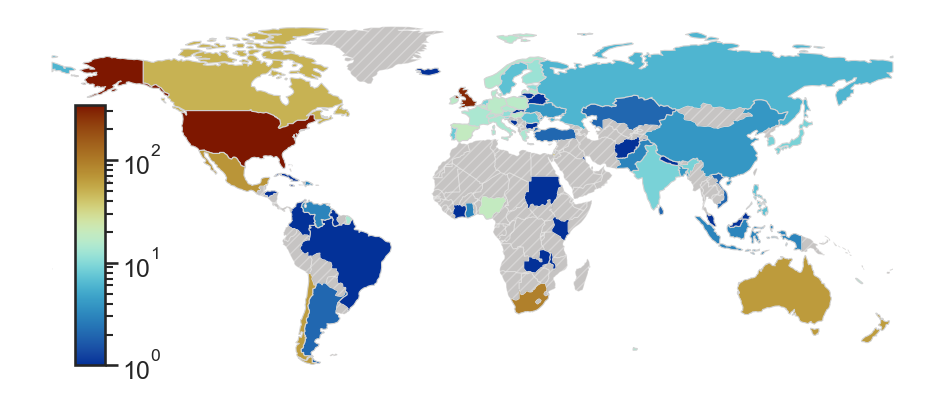

In [35]:
import geopandas as gpd
import matplotlib.colors as colors


def plot_choropleth_by_country_name(
    save_path, save_name, df, title, col, world, figsize=(10, 10), log_scale=False
):
    # Remove the south pole!
    world = world[world["SOVEREIGNT"] != "Antarctica"]
    # Merge data with the world GeoDataFrame
    merged = world.set_index("ISO_A3").join(df.set_index(col))
    merged["count"] = merged["count"].replace(0, float("nan"))

    # Determine the normalization based on log_scale
    norm = (
        colors.LogNorm(vmin=merged["count"].min(), vmax=merged["count"].max())
        if log_scale
        else None
    )

    # Create the plot
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    choropleth = merged.plot(
        column="count",
        ax=ax,
        cmap=palettes_dict["rainbow"].reversed(),
        edgecolor="lightgrey",
        linewidth=0.8,
        missing_kwds={
            "color": basic_colors_dict["darkgrey"],
            "alpha": 0.3,
            "edgecolor": "white",
            "hatch": "///",
        },
        norm=norm,
    )
    plt.title(title)
    plt.subplots_adjust(left=0.025, right=0.95, top=0.95, bottom=0.05)

    plt.axis("off")

    # Adjust the height value to make the colorbar smaller
    cbar_ax = fig.add_axes([0.09, 0.33, 0.03, 0.26])  # [left, bottom, width, height]
    sm = plt.cm.ScalarMappable(cmap=palettes_dict["rainbow"].reversed(), norm=norm)
    sm._A = []  # Fake up the array of the scalar mappable. Urgh...
    fig.colorbar(sm, cax=cbar_ax)

    plt.show()

    ensure_dir_exists(save_path)
    fig.savefig(f"{save_path}/{save_name}.pdf", format="pdf", bbox_inches="tight")
    return fig


# You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/
world = gpd.read_file(
    f"{PROJECT_ROOT}/data/storage/worldmap/ne_110m_admin_0_countries.shp"
)

# Fix the missing ISO A3 codes for Norway
world.loc[world["SOVEREIGNT"] == "Norway", "ISO_A3"] = "NOR"
world.loc[world["SOVEREIGNT"] == "France", "ISO_A3"] = "FRA"


# Define the columns to check
cols = ["location_birth_countryISO"]

# Get unique country names from the world GeoDataFrame
world_countries = set(world["ISO_A3"].unique())

# Initialize sets for unmatched countries
countries_not_in_df = set()
countries_not_in_world = set()

# Check each column
for col in cols:
    # Get unique country names
    df_countries = set(survey[col].dropna().unique())

    # Find countries in 'world' not in 'df' and vice versa
    countries_not_in_df.update(world_countries - df_countries)
    countries_not_in_world.update(df_countries - world_countries)

# Print the lists
# print("Countries in 'world' but not in 'df':", countries_not_in_df) (should now be fixed)
print("Countries in 'df' but not in 'world':", countries_not_in_world)

# # Remap (these should be fixed now)
# remap_country_name = {'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom',
#                       'Russian Federation': 'Russia',
#                       'Czech Republic': 'Czechia',
#                       'Hong Kong (S.A.R.)': 'Hong Kong',
#                       "Côte d'Ivoire":'Ivory Coast',
#                       'Venezuela, Bolivarian Republic of...': 'Venezuela'
#                       }

# Replace the country names in the DataFrame
# for col in cols:

#     survey[col] = survey[col].replace(remap_country_name)

# print("Countries still in 'df' but not in 'world':", countries_not_in_world)

for col in cols:
    df = survey[col].value_counts().reset_index()
    df.columns = [col, "count"]
    stub = col.split("_")[0]
    title = ""
    save_path = f"{RESULTS_PATH}/plots/summary_plots"
    save_name = "worldmap_birth_countries"
    fig = plot_choropleth_by_country_name(
        save_path, save_name, df, title, col, world, log_scale=True
    )

## Regional Entropy Plot

In [36]:
# Check how many people have birth country == reside country
birth_reside = survey[
    survey["location_birth_countryISO"] != survey["location_reside_countryISO"]
]
print(
    f"Number of people with birth country != reside country: {len(birth_reside)} ({len(birth_reside) / len(survey):.2%})"
)

Number of people with birth country != reside country: 179 (11.93%)


In [37]:
# Create Treemap
import plotly.express as px

plot_data = survey[
    ["location_special_region", "location_birth_subregion", "location_birth_countryISO"]
]
# Create a Treemap with percentages
fig = px.treemap(
    plot_data,
    path=[
        "location_special_region",
        "location_birth_subregion",
        "location_birth_countryISO",
    ],
    width=1000,  # Approx A4
    height=1000 * 1.41,  # Approx A4
    color_discrete_sequence=px.colors.diverging.Portland,
    hover_data=plot_data.columns,
)


# Update the layout to include the percent
fig.update_traces(
    texttemplate="%{label}<br>%{percentParent:.0%}", textposition="middle center"
)

fig.update_traces(textfont=dict(size=15))

# Adjust layout for better fit
fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))

fig.show()

fig.write_image(
    f"{RESULTS_PATH}/plots/summary_plots/treemap_regions_portrait.pdf",
    width=595,
    height=842,
)

In [38]:
# In Middle East, inspect breakdowns as example of sample skew
middle_east = survey[survey["location_special_region"] == "Middle East"]
print(middle_east[["ethnicity_simplified"]].value_counts(normalize=True))
print(
    middle_east[["ethnicity_simplified", "ethnicity_self_described"]].value_counts(
        normalize=True
    )
)

ethnicity_simplified
Other                   0.40
White                   0.38
Prefer not to say       0.14
Mixed                   0.06
Asian                   0.02
Name: proportion, dtype: float64
ethnicity_simplified  ethnicity_self_described 
White                 white                        0.16
Other                 jewish                       0.14
Prefer not to say     prefer not to say            0.12
White                 caucasian                    0.10
Other                 middle eastern               0.08
White                 israeli                      0.04
Other                 ashkenazi jew                0.04
                      middle-eastern               0.04
Asian                 asian                        0.02
White                 white male                   0.02
                      turkish                      0.02
                      caucation                    0.02
Prefer not to say     ukranian-israelite           0.02
Other                 mid

# MetaData

In [39]:
metadata = data_dict["metadata"]
nested_columns = ["moderation_flag"]
metadata = unnest_columns(metadata, nested_columns)

### General Summary of Flags

In [40]:
categorical = {
    "en_flag": "Is English",
    "pii_flag": "Contains PII",
    "pii_manual_flag": "Manually-Checked PII",
    "moderation_flag_flagged": "Is Moderation Flagged",
}

# Print overall counts
print("Overall counts")
for c, l in categorical.items():
    print(f"{l}: {metadata[c].value_counts(normalize=True).to_dict()}")

# Get unique column names
unique_columns = ["Overall"]
for c in metadata["column_id"].unique():
    unique_columns.append(c)


# Initialize the first row of the DataFrame
first_row = [""] + list(unique_columns)

# Initialize the list for storing rows
rows = []


# "N (%)" format
rows = []
for c, l in categorical.items():
    row = [l]  # Start the row with the label of the category
    # Add overall
    for col in unique_columns:
        if col == "Overall":
            subset = metadata.copy()
        else:
            subset = metadata[metadata["column_id"] == col]
        count = len(subset[subset[c] == True])
        percentage = (count / len(subset)) * 100 if len(subset) > 0 else 0

        if (c == "pii_manual_flag") & (col == "model_response"):
            row.append(np.nan)  # Adjusted to append NaN as a single cell
        else:
            # Combine count and percentage in the desired format and append as a single cell
            row.append(f"{count:,.0f} ({percentage:.1f}\\%)")
    rows.append(row)


total_row = ["Total Instances"]
for col in unique_columns:
    if col == "Overall":
        total_count = len(metadata)
    else:
        total_count = len(metadata[metadata["column_id"] == col])
    total_row.append(f"{total_count:,.0f} (100.0\\%)")
rows.append(total_row)

# Create df
df = pd.DataFrame(rows, columns=["Category"] + list(unique_columns))

# Transpose the DataFrame
df = df.T

# Set the first row as the header
df.columns = df.iloc[0]
# Drop the first row
df = df[1:]

display(df)


# Make sure the index is bold
df.index = [f"\\texttt{{{index.replace('_', '\\_')}}}" for index in df.index]

styled_df = df.style.set_properties(**{"text-align": "center"})

# Convert to latex
latex_str = styled_df.to_latex(
    hrules=True,
    convert_css=True,
    environment=None,
    caption="ADD CAPTION HERE",
    label="tab:ADD_LABEL_HERE",
)

# Print the latex string
print(latex_str)

Overall counts
Is English: {True: 0.987564990521238, False: 0.012435009478761942}
Contains PII: {False: 0.9895733618634683, True: 0.010426638136531712}
Manually-Checked PII: {0.0: 1.0}
Is Moderation Flagged: {False: 0.9940499652758226, True: 0.005950034724177412}


Category,Is English,Contains PII,Manually-Checked PII,Is Moderation Flagged,Total Instances
Overall,"105,229 (98.8\%)","1,111 (1.0\%)",0 (0.0\%),634 (0.6\%),"106,554 (100.0\%)"
user_prompt,"26,545 (97.7\%)",66 (0.2\%),0 (0.0\%),454 (1.7\%),"27,172 (100.0\%)"
model_response,"67,715 (99.0\%)",944 (1.4\%),NaN,162 (0.2\%),"68,371 (100.0\%)"
self_description,"1,496 (99.7\%)",10 (0.7\%),0 (0.0\%),7 (0.5\%),"1,500 (100.0\%)"
system_string,"1,493 (99.5\%)",16 (1.1\%),0 (0.0\%),0 (0.0\%),"1,500 (100.0\%)"
open_feedback,"7,980 (99.6\%)",75 (0.9\%),0 (0.0\%),11 (0.1\%),"8,011 (100.0\%)"


\begin{table}
\caption{ADD CAPTION HERE}
\label{tab:ADD_LABEL_HERE}
\begin{tabular}{llllll}
\toprule
Category & Is English & Contains PII & Manually-Checked PII & Is Moderation Flagged & Total Instances \\
\midrule
\texttt{Overall} & 105,229 (98.8\%) & 1,111 (1.0\%) & 0 (0.0\%) & 634 (0.6\%) & 106,554 (100.0\%) \\
\texttt{user\_prompt} & 26,545 (97.7\%) & 66 (0.2\%) & 0 (0.0\%) & 454 (1.7\%) & 27,172 (100.0\%) \\
\texttt{model\_response} & 67,715 (99.0\%) & 944 (1.4\%) & nan & 162 (0.2\%) & 68,371 (100.0\%) \\
\texttt{self\_description} & 1,496 (99.7\%) & 10 (0.7\%) & 0 (0.0\%) & 7 (0.5\%) & 1,500 (100.0\%) \\
\texttt{system\_string} & 1,493 (99.5\%) & 16 (1.1\%) & 0 (0.0\%) & 0 (0.0\%) & 1,500 (100.0\%) \\
\texttt{open\_feedback} & 7,980 (99.6\%) & 75 (0.9\%) & 0 (0.0\%) & 11 (0.1\%) & 8,011 (100.0\%) \\
\bottomrule
\end{tabular}
\end{table}



### Digging into Moderation Categories

In [41]:
frames = []
for split in ["Human written", "Model written"]:
    if split == "Human written":
        hum_cols = ["user_prompt", "self_description", "system_string", "open_feedback"]
        subset = metadata[metadata["column_id"].isin(hum_cols)]
    else:
        mod_cols = ["model_response"]
        subset = metadata[metadata["column_id"].isin(mod_cols)]
    headers = []
    rows = []
    columns = [c for c in subset.columns if "moderation_flag_categories" in c]
    for c in columns:
        headers.append(c)
        # Get true count from value counts
        r = subset[c].value_counts(dropna=False)
        sum = r.sum()
        r_sort = r.sort_values(ascending=False)
        r_pct = (r_sort / sum) * 100
        r_combine = pd.concat([r_sort, r_pct], ignore_index=True, axis=1)
        r_combine.columns = ["count", "pct"]
        for i, row in r_combine.iterrows():
            if i == True:
                rows.append([c.split(".")[-1], row["count"], row["pct"]])

    # Total row
    total_row = ["Total", len(subset), 100]
    rows.append(total_row)

    # Dataframe
    df = pd.DataFrame(rows, columns=["Category", "N", "(%)"])

    frames.append(df)

# Combine
combined_df = frames[0].merge(frames[1], on="Category", suffixes=("_human", "_model"))

# Add multiindex (first three columns are human written, last three are model written)
top_level = [""] + ["Human-written"] * 2 + ["Model-written"] * 2

# Create a list for the second level of the MultiIndex (original column names)
second_level = [c.split("_")[0] for c in combined_df.columns]

# Create the MultiIndex using the top_level and second_level lists
multi_index = pd.MultiIndex.from_arrays([top_level, second_level])

# Assign the MultiIndex to the columns of the DataFrame
combined_df.columns = multi_index

# Make sure the first column is bold
combined_df = combined_df.set_index(combined_df.columns[0])
combined_df.index = [f"\\textbf{{{index}}}" for index in combined_df.index]

display(combined_df)

# Center the text
styled_df = combined_df.style.set_properties(**{"text-align": "center"})

styled_df = styled_df.format(
    {
        col: "{:,.0f}" if "N" in col[1] else "{:.2f}\\%" if "%" in col[1] else "{}"
        for col in combined_df.columns
    }
)


# Convert to latex
latex_str = styled_df.to_latex(
    hrules=True,
    convert_css=True,
    environment=None,
    caption="ADD CAPTION HERE",
    label="tab:ADD_LABEL_HERE",
)

print(latex_str)

Human-written             Model-written  \
                                            N         (%)             N   
\textbf{sexual}                          21.0    0.054998          11.0   
\textbf{hate}                           154.0    0.403321          36.0   
\textbf{harassment}                     387.0    1.013540         127.0   
\textbf{self-harm}                       24.0    0.062855           8.0   
\textbf{sexual/minors}                    4.0    0.010476           4.0   
\textbf{hate/threatening}                17.0    0.044522           2.0   
\textbf{self-harm/intent}                26.0    0.068093           5.0   
\textbf{self-harm/instructions}          13.0    0.034047           8.0   
\textbf{harassment/threatening}          33.0    0.086426           7.0   
\textbf{violence}                        52.0    0.136186          13.0   
\textbf{Total}                        38183.0  100.000000       68371.0   

                                             
                                        (%)  
\textbf{sexual}                    0.016089  
\textbf{hate}                      0.052654  
\textbf{harassment}                0.185751  
\textbf{self-harm}                 0.011701  
\textbf{sexual/minors}             0.005850  
\textbf{hate/threatening}          0.002925  
\textbf{self-harm/intent}          0.007313  
\textbf{self-harm/instructions}    0.011701  
\textbf{harassment/threatening}    0.010238  
\textbf{violence}                  0.019014  
\textbf{Total}                   100.000000

\begin{table}
\caption{ADD CAPTION HERE}
\label{tab:ADD_LABEL_HERE}
\begin{tabular}{lrrrr}
\toprule
 & \multicolumn{2}{r}{Human-written} & \multicolumn{2}{r}{Model-written} \\
 & N & (%) & N & (%) \\
\midrule
\textbf{sexual} & 21 & 0.05\% & 11 & 0.02\% \\
\textbf{hate} & 154 & 0.40\% & 36 & 0.05\% \\
\textbf{harassment} & 387 & 1.01\% & 127 & 0.19\% \\
\textbf{self-harm} & 24 & 0.06\% & 8 & 0.01\% \\
\textbf{sexual/minors} & 4 & 0.01\% & 4 & 0.01\% \\
\textbf{hate/threatening} & 17 & 0.04\% & 2 & 0.00\% \\
\textbf{self-harm/intent} & 26 & 0.07\% & 5 & 0.01\% \\
\textbf{self-harm/instructions} & 13 & 0.03\% & 8 & 0.01\% \\
\textbf{harassment/threatening} & 33 & 0.09\% & 7 & 0.01\% \\
\textbf{violence} & 52 & 0.14\% & 13 & 0.02\% \\
\textbf{Total} & 38,183 & 100.00\% & 68,371 & 100.00\% \\
\bottomrule
\end{tabular}
\end{table}



### Digging into Languages

In [42]:
frames = []
for split in ["Human written", "Model written"]:
    if split == "Human written":
        hum_cols = ["user_prompt", "self_description", "system_string", "open_feedback"]
        subset = metadata[metadata["column_id"].isin(hum_cols)]
    else:
        mod_cols = ["model_response"]
        subset = metadata[metadata["column_id"].isin(mod_cols)]
    headers = []
    rows = []
    columns = ["language_flag"]
    for c in columns:
        headers.append(c)
        # Get value counts
        r = subset[c].value_counts(dropna=False)
        sum = r.sum()
        r_sort = r.sort_values(ascending=False)
        r_pct = (r_sort / sum) * 100
        r_combine = pd.concat([r_sort, r_pct], ignore_index=True, axis=1)
        r_combine.columns = ["count", "pct"]
        for rank, (i, row) in enumerate(r_combine.iterrows()):
            if rank < 10:
                rows.append([i, row["count"], row["pct"]])
        # Append "other" for rest of rows
        other_count = r_combine.iloc[10:, 0].sum()
        other_pct = r_combine.iloc[10:, 1].sum()
        rows.append(["Other", other_count, other_pct])

    # Total row
    total_row = ["Total", len(subset), 100]
    rows.append(total_row)

    # Dataframe
    df = pd.DataFrame(rows, columns=["Lang", "N", "(%)"])

    frames.append(df)

# Combine
combined_df = pd.concat(frames, axis=1)

# Add multiindex (first three columns are human written, last three are model written)
top_level = ["Human-written"] * 3 + ["Model-written"] * 3

# Create a list for the second level of the MultiIndex (original column names)
second_level = combined_df.columns

# Create the MultiIndex using the top_level and second_level lists
multi_index = pd.MultiIndex.from_arrays([top_level, second_level])

# Assign the MultiIndex to the columns of the DataFrame
combined_df.columns = multi_index

combined_df.index = [index + 1 for index in combined_df.index]

display(combined_df)

# Center the text
styled_df = combined_df.style.set_properties(**{"text-align": "center"})

styled_df = styled_df.format(
    {
        col: "{:,.0f}" if "N" in col[1] else "{:.2f}\\%" if "%" in col[1] else "{}"
        for col in combined_df.columns
    }
)


# Convert to latex
latex_str = styled_df.to_latex(
    hrules=True,
    convert_css=True,
    environment=None,
    caption="ADD CAPTION HERE",
    label="tab:ADD_LABEL_HERE",
)

print(latex_str)

Human-written                      Model-written                     
            Lang        N         (%)          Lang        N         (%)
1             en  37514.0   98.247911            en  67715.0   99.040529
2             es    175.0    0.458319            es    236.0    0.345176
3             fr     71.0    0.185947            de     67.0    0.097995
4             it     70.0    0.183328            fr     63.0    0.092144
5             de     60.0    0.157138            la     43.0    0.062892
6             nl     42.0    0.109997            nl     37.0    0.054117
7             pt     41.0    0.107378            it     29.0    0.042416
8             pl     34.0    0.089045            sl     19.0    0.027790
9             da     24.0    0.062855            hu     15.0    0.021939
10            ro     13.0    0.034047            sv     14.0    0.020477
11         Other    139.0    0.364036         Other    133.0    0.194527
12         Total  38183.0  100.000000         Total  68371.0  100.000000

\begin{table}
\caption{ADD CAPTION HERE}
\label{tab:ADD_LABEL_HERE}
\begin{tabular}{llrrlrr}
\toprule
 & \multicolumn{3}{r}{Human-written} & \multicolumn{3}{r}{Model-written} \\
 & Lang & N & (%) & Lang & N & (%) \\
\midrule
1 & en & 37,514 & 98.25\% & en & 67,715 & 99.04\% \\
2 & es & 175 & 0.46\% & es & 236 & 0.35\% \\
3 & fr & 71 & 0.19\% & de & 67 & 0.10\% \\
4 & it & 70 & 0.18\% & fr & 63 & 0.09\% \\
5 & de & 60 & 0.16\% & la & 43 & 0.06\% \\
6 & nl & 42 & 0.11\% & nl & 37 & 0.05\% \\
7 & pt & 41 & 0.11\% & it & 29 & 0.04\% \\
8 & pl & 34 & 0.09\% & sl & 19 & 0.03\% \\
9 & da & 24 & 0.06\% & hu & 15 & 0.02\% \\
10 & ro & 13 & 0.03\% & sv & 14 & 0.02\% \\
11 & Other & 139 & 0.36\% & Other & 133 & 0.19\% \\
12 & Total & 38,183 & 100.00\% & Total & 68,371 & 100.00\% \\
\bottomrule
\end{tabular}
\end{table}



## Model Table

In [43]:
models = data_dict["models"]
print(models.columns)
# # Get model mapping
model_mapping = pd.read_csv(
    PROJECT_ROOT / "data" / "storage" / "mappings" / "model_mapping.csv"
)


print(model_mapping.columns)

# Subset cols
keep_cols = [
    "short_name",
    "long_name",
    "model_provider",
    "model_provider_type",
    "model_type",
]
models = models[keep_cols]


# Sort by model_provider/short_name
models = models.sort_values(by=["model_provider", "short_name"])


# Double check we don't use Open Source
models["model_provider_type"] = models["model_provider_type"].replace(
    "Open Source", "Open Access"
)

# Replace Aleph Alpha
models["model_provider"] = models["model_provider"].replace("Aleph", "Aleph Alpha")

# Rename columns (capitals and replace _ with space)
models.columns = [c.capitalize().replace("_", " ") for c in models.columns]


# Function to escape LaTeX special characters
def escape_latex(s):
    special_chars = ["&", "%", "$", "#", "_", "{", "}", "~", "^", "\\"]
    escape_chars = [
        "\\&",
        "\\%",
        "\\$",
        "\\#",
        "\\_",
        "\\{",
        "\\}",
        "\\textasciitilde{}",
        "\\textasciicircum{}",
        "\\textbackslash{}",
    ]
    for special, escape in zip(special_chars, escape_chars):
        if special in s:
            s = s.replace(special, escape)
    return s


# Assuming 'models' is your DataFrame
for col in models.select_dtypes(include=[object]):
    models[col] = models[col].apply(escape_latex)

display(models.head(2))

# Latex long table
latex_str = models.to_latex(
    index=False,
    longtable=False,
    escape=False,
    caption="ADD CAPTION HERE",
    label="tab:ADD_LABEL_HERE",
)

print(latex_str)

Index(['long_name', 'short_name', 'longcode', 'model_family', 'model_provider',
       'model_provider_type', 'model_type', 'default_params',
       'selected_params', 'header', 'link', 'in_yaml', 'params_tested',
       'endpoint_live', 'status'],
      dtype='object')
Index(['long_name', 'short_name'], dtype='object')


,Short name,Long name,Model provider,Model provider type,Model type
11,luminous-extended-control,luminous-extended-control,Aleph Alpha,Commerical,Instruct
12,luminous-supreme-control,luminous-supreme-control,Aleph Alpha,Commerical,Instruct


\begin{table}
\caption{ADD CAPTION HERE}
\label{tab:ADD_LABEL_HERE}
\begin{tabular}{lllll}
\toprule
Short name & Long name & Model provider & Model provider type & Model type \\
\midrule
luminous-extended-control & luminous-extended-control & Aleph Alpha & Commerical & Instruct \\
luminous-supreme-control & luminous-supreme-control & Aleph Alpha & Commerical & Instruct \\
claude-2 & claude-2 & Anthropic & Commerical & Chat \\
claude-2.1 & claude-2.1 & Anthropic & Commerical & Chat \\
claude-instant-1 & claude-instant-1 & Anthropic & Commerical & Chat \\
command & command & Cohere & Commerical & Instruct \\
command-light & command-light & Cohere & Commerical & Instruct \\
command-nightly & command-nightly & Cohere & Commerical & Instruct \\
palm-2 & models/chat-bison-001 & Google & Commerical & Chat \\
falcon-7b-instruct & tiiuae/falcon-7b-instruct & HuggingFace-API & Open Access & Instruct \\
flan-t5-xxl & google/flan-t5-xxl & HuggingFace-API & Open Access & Instruct \\
guanaco-33b & t

In [44]:
# Save for some extra formatting
models.sort_values(by="Short name").to_clipboard()